# Goal
Demonstrate how GRAD-CAM and Integrated Gradients highlight different visual mechanisms
(modality vs. lesion-level features) when explaining tumor predictions from MRI scans.

# Background

This notebook analyzes a 6-class tumor classifier trained on:
- **Brain MRI:** No Tumor, Glioma, Meningioma, Pituitary
- **Breast MRI:** Benign, Malignant

Because the model handles two imaging modalities, it learns a hierarchical decision process:
1. First, discriminate between brain and breast anatomy
2. Then, classify the specific tumor into one of the 6 classes

This dual-task learning creates distinct attribution patterns that we'll explore below.

## 1. Setup & Load Artifacts

In [52]:
# Add parent directory to path for imports
import sys, os
sys.path.append(os.path.abspath(".."))
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

from src.explainability import grad_cam, integrated_gradients


In [45]:
# Reload the full test set from artifacts
X_test = np.load("../artifacts/X_test_sample.npy")
y_test = np.load("../artifacts/y_test_sample.npy")

print(f"X_test shape: {X_test.shape}")  # Should show (4739, 128, 128, 3)
print(f"y_test shape: {y_test.shape}")  # Should show (4739, 6)

X_test shape: (4739, 128, 128, 3)
y_test shape: (4739, 6)


In [18]:
import tensorflow as tf
from src.model_trigconv2d import TrigConv2D  # Import the custom layer

# Load from artifacts
model = tf.keras.models.load_model(
    "../artifacts/trigconv_model.keras",
    custom_objects={'TrigConv2D': TrigConv2D}
)

print("✅ Model loaded from artifacts!")


✅ Model loaded from artifacts!


## 2. Explainability Case Studies
- **Original scan** with ground truth label
- **GRAD-CAM overlay** showing regional activation from the final convolutional layer
- **Integrated Gradients overlay** showing pixel-level attribution
- **Prediction confidence** across all classes

### CASE 1: BREAST MRI - BENIGN

BREAST MRI SCAN: Benign
Computing GRAD-CAM...
Computing Integrated Gradients (this takes up to 10 seconds)...


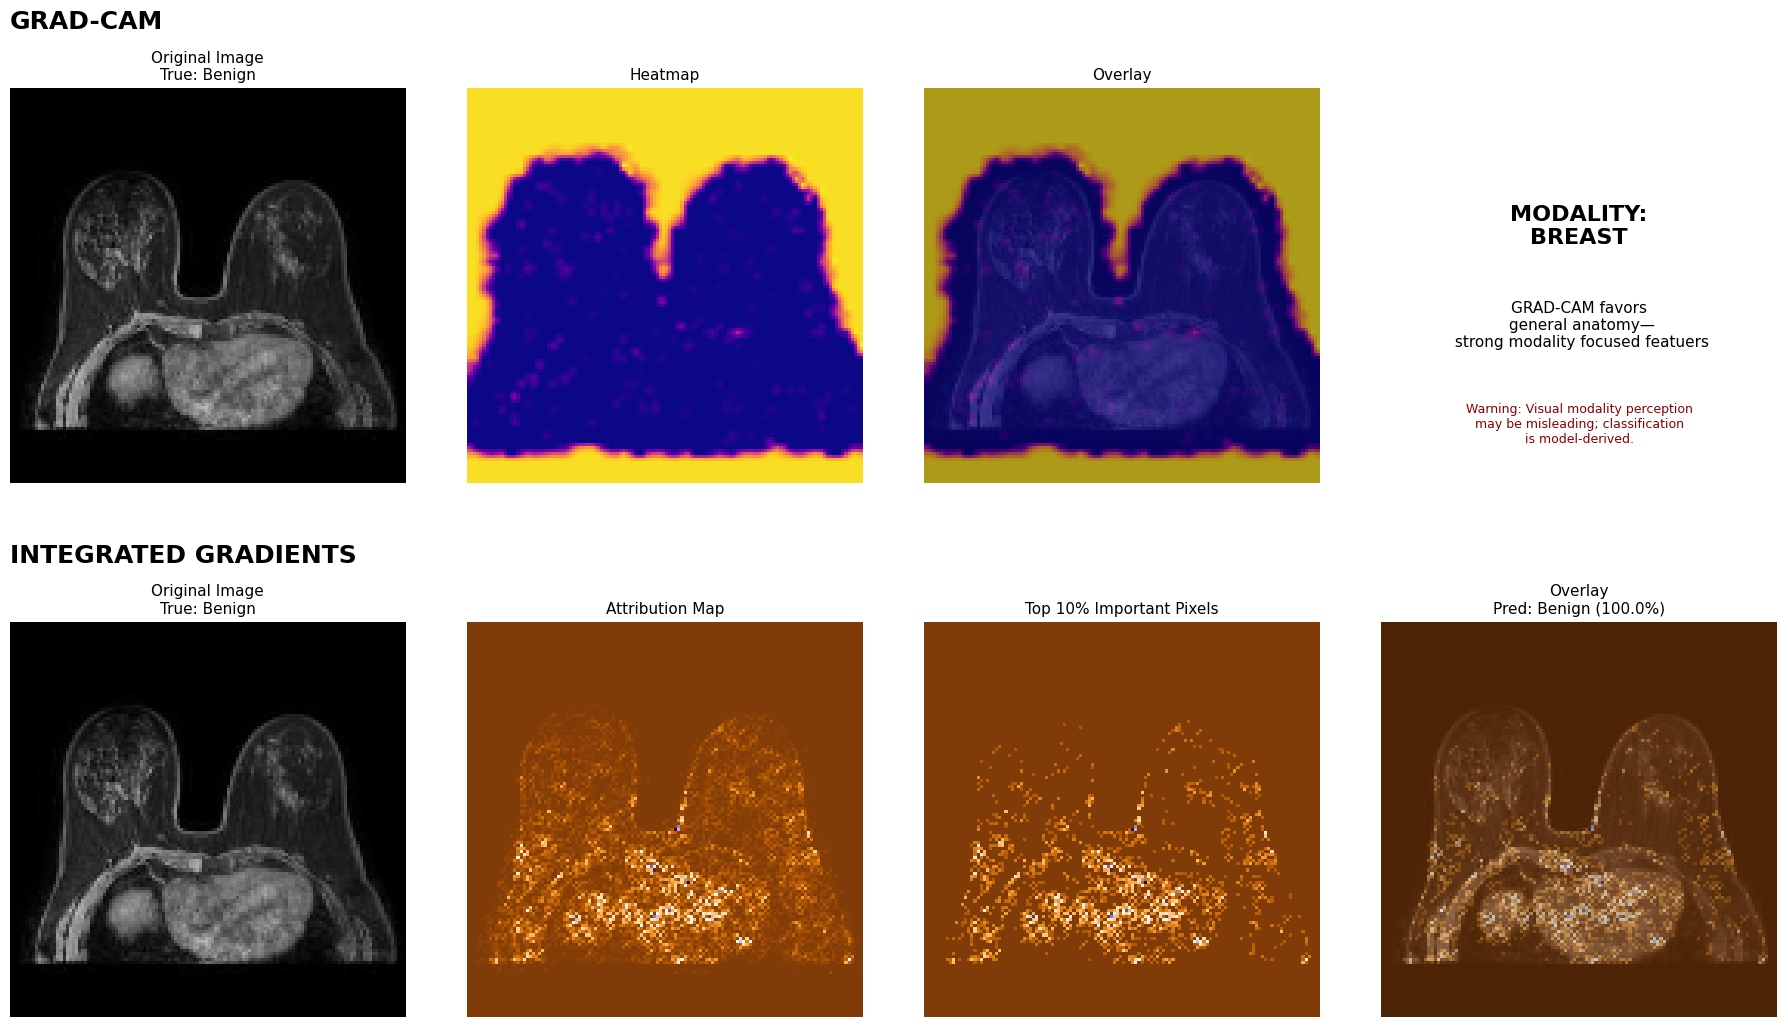

In [69]:
class_names = ['Benign', 'Malignant', 'No Tumor', 'Glioma Tumor', 'Meningioma Tumor', 'Pituitary Tumor']

sample_idx = 3000
sample_img = X_test[sample_idx]
true_lbl = class_names[np.argmax(y_test[sample_idx])]

# Get prediction
pred_probs = model.predict(np.expand_dims(sample_img, axis=0), verbose=0)[0]
pred_class = np.argmax(pred_probs)
confidence = pred_probs[pred_class] * 100

# Determine modality
if class_names[pred_class] in ['No Tumor', 'Glioma Tumor', 'Pituitary Tumor', 'Meningioma Tumor']:
    modality = "BRAIN"
else:
    modality = "BREAST"

print(f"{modality} MRI SCAN: {class_names[pred_class]}")
print("Computing GRAD-CAM...")
grad_vis, grad_out = grad_cam(model, sample_img, pred_class)

print("Computing Integrated Gradients (this takes up to 10 seconds)...")
attributions, preds = integrated_gradients(model, sample_img, pred_class, steps=100)

# Process IG attributions
attr_magnitude = np.sum(np.abs(attributions), axis=-1)
attr_magnitude = attr_magnitude / (attr_magnitude.max() + 1e-10)
threshold = np.percentile(attr_magnitude, 90)
attr_thresholded = np.where(attr_magnitude > threshold, attr_magnitude, 0)

# Create 2x4 figure
fig, axes = plt.subplots(2, 4, figsize=(18, 10))

# ============= ROW TITLES (above each row) =============
axes[0, 0].annotate('GRAD-CAM', xy=(0, 1.15), xycoords='axes fraction', 
                     fontsize=18, fontweight='bold', ha='left')
axes[1, 0].annotate('INTEGRATED GRADIENTS', xy=(0, 1.15), xycoords='axes fraction', 
                     fontsize=18, fontweight='bold', ha='left')

# ============= TOP ROW: GRAD-CAM =============
axes[0, 0].imshow(sample_img)
axes[0, 0].set_title(f'Original Image\nTrue: {true_lbl}', fontsize=11)
axes[0, 0].axis('off')

axes[0, 1].imshow(grad_vis, cmap='plasma')
axes[0, 1].set_title('Heatmap', fontsize=11)
axes[0, 1].axis('off')

axes[0, 2].imshow(sample_img)
axes[0, 2].imshow(grad_vis, cmap='plasma', alpha=0.7)
axes[0, 2].set_title('Overlay', fontsize=11)
axes[0, 2].axis('off')

axes[0, 3].axis('off')
axes[0, 3].text(0.5, 0.65, f"MODALITY:\n{modality}", ha='center', va='center', fontsize=16, fontweight='bold')
axes[0, 3].text(0.5, 0.4, "GRAD-CAM favors\n general anatomy—\n strong modality focused featuers", ha='center', va='center', fontsize=11)
axes[0, 3].text(0.5, 0.15, "Warning: Visual modality perception\nmay be misleading; classification\nis model-derived.", ha='center', va='center', fontsize=9, color='darkred', bbox=dict(facecolor='white', alpha=0.7, edgecolor='none'))

# ============= BOTTOM ROW: INTEGRATED GRADIENTS =============
axes[1, 0].imshow(sample_img)
axes[1, 0].set_title(f'Original Image\nTrue: {true_lbl}', fontsize=11)
axes[1, 0].axis('off')

axes[1, 1].imshow(attr_magnitude, cmap='PuOr')
axes[1, 1].set_title('Attribution Map', fontsize=11)
axes[1, 1].axis('off')

axes[1, 2].imshow(attr_thresholded, cmap='PuOr')
axes[1, 2].set_title('Top 10% Important Pixels', fontsize=11)
axes[1, 2].axis('off')

axes[1, 3].imshow(sample_img)
axes[1, 3].imshow(attr_thresholded, cmap='PuOr', alpha=0.6)
axes[1, 3].set_title(f'Overlay\nPred: {class_names[pred_class]} ({confidence:.1f}%)', fontsize=11)
axes[1, 3].axis('off')

plt.tight_layout()
plt.subplots_adjust(hspace=0.35)  # Add space between rows for the titles
plt.show()

**Interpretation: CASE 1 - Benign**
- Grad-CAM highlights large modality-driven anatomical boundaries
  → useful for structural localization but sometimes distracts from tumor regions.
  → does not explain tumor classification reasoning that much.
- Integrated Gradients focuses on hyperintense lesion core
  → pixel-level details are highlighted thus explaining tumor classification reasoning of model.
  → aligns more with radiologist attention & perfusion-weighted signal changes.

**Takeaway:** Tumor-localizing interpretations often require IG overlays
because Grad-CAM captures “where the model looks to classify modality,”
not *where the pathology is*. For medical interpretation, Integrated Gradients is more clinically meaningful.


### CASE 2: BRAIN MRI - GLIOMA TUMOR

BRAIN MRI SCAN: Glioma Tumor
Computing GRAD-CAM...
Computing Integrated Gradients (this takes up to 10 seconds)...


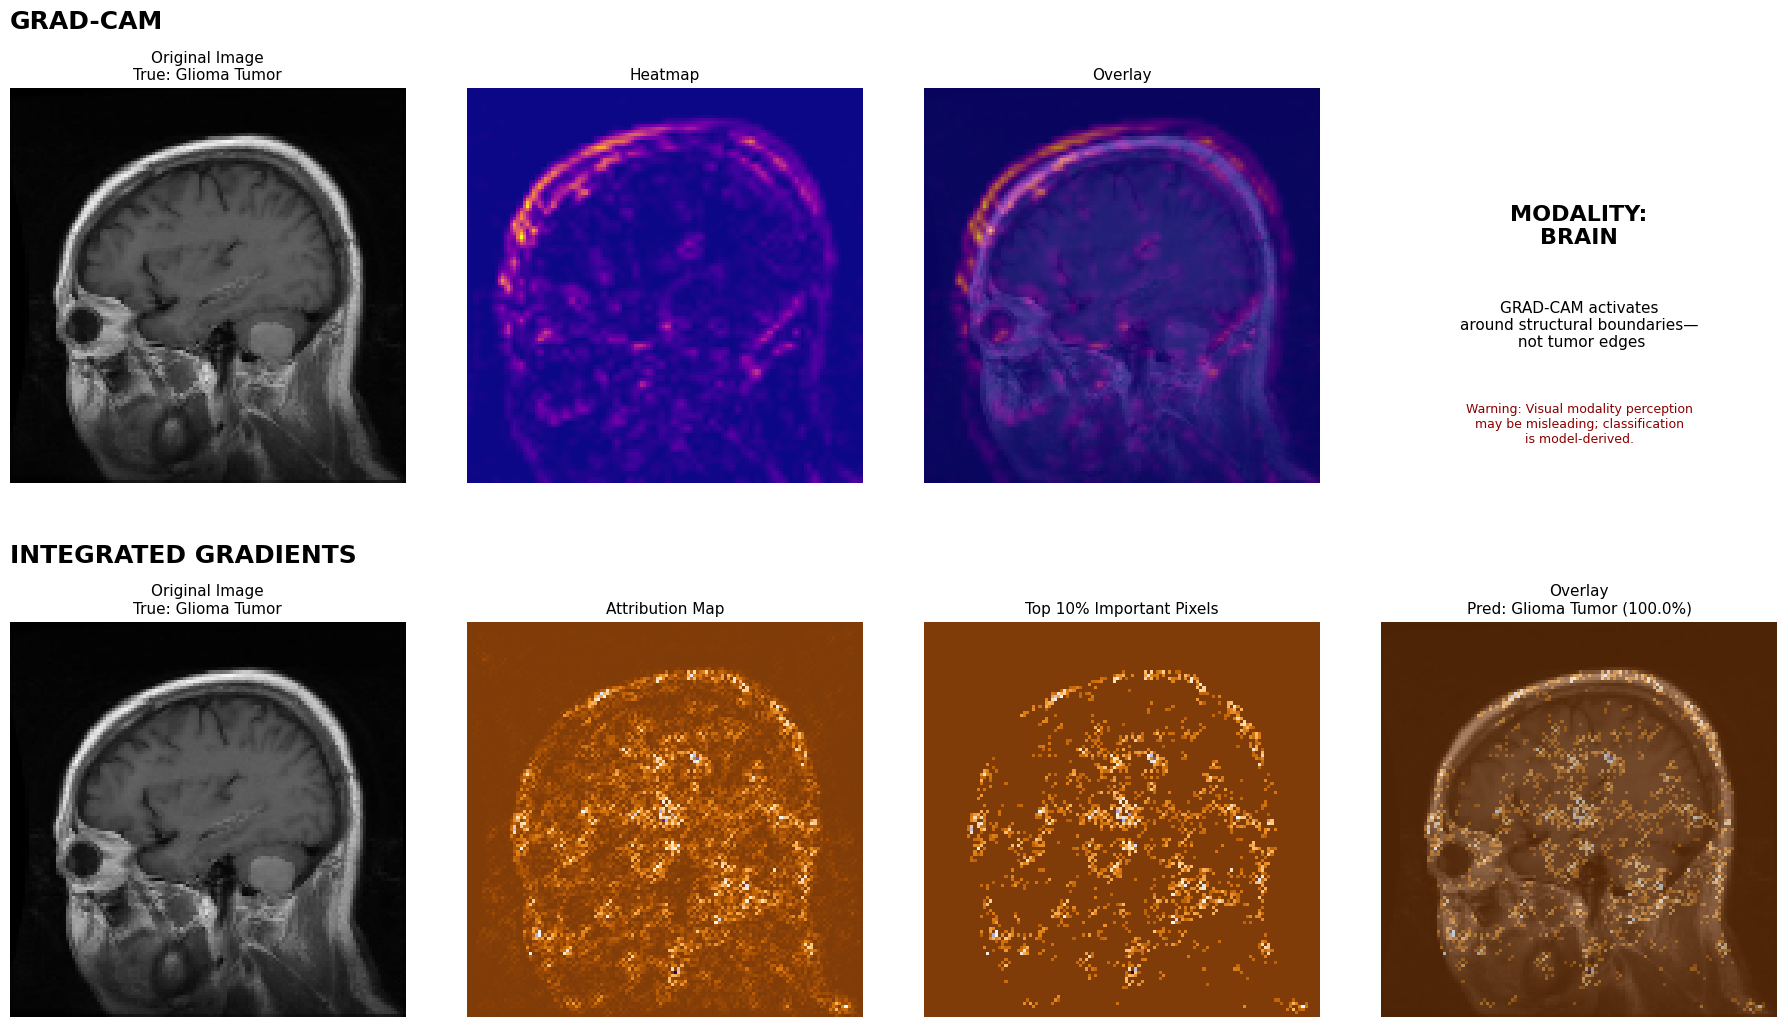

In [70]:
class_names = ['Benign', 'Malignant', 'No Tumor', 'Glioma Tumor', 'Meningioma Tumor', 'Pituitary Tumor']

sample_idx = 4596
sample_img = X_test[sample_idx]
true_lbl = class_names[np.argmax(y_test[sample_idx])]

# Get prediction
pred_probs = model.predict(np.expand_dims(sample_img, axis=0), verbose=0)[0]
pred_class = np.argmax(pred_probs)
confidence = pred_probs[pred_class] * 100

# Determine modality
if class_names[pred_class] in ['No Tumor', 'Glioma Tumor', 'Pituitary Tumor', 'Meningioma Tumor']:
    modality = "BRAIN"
else:
    modality = "BREAST"

print(f"{modality} MRI SCAN: {class_names[pred_class]}")
print("Computing GRAD-CAM...")
grad_vis, grad_out = grad_cam(model, sample_img, pred_class)

print("Computing Integrated Gradients (this takes up to 10 seconds)...")
attributions, preds = integrated_gradients(model, sample_img, pred_class, steps=100)

# Process IG attributions
attr_magnitude = np.sum(np.abs(attributions), axis=-1)
attr_magnitude = attr_magnitude / (attr_magnitude.max() + 1e-10)
threshold = np.percentile(attr_magnitude, 90)
attr_thresholded = np.where(attr_magnitude > threshold, attr_magnitude, 0)

# Create 2x4 figure
fig, axes = plt.subplots(2, 4, figsize=(18, 10))

# ============= ROW TITLES (above each row) =============
axes[0, 0].annotate('GRAD-CAM', xy=(0, 1.15), xycoords='axes fraction', 
                     fontsize=18, fontweight='bold', ha='left')
axes[1, 0].annotate('INTEGRATED GRADIENTS', xy=(0, 1.15), xycoords='axes fraction', 
                     fontsize=18, fontweight='bold', ha='left')

# ============= TOP ROW: GRAD-CAM =============
axes[0, 0].imshow(sample_img)
axes[0, 0].set_title(f'Original Image\nTrue: {true_lbl}', fontsize=11)
axes[0, 0].axis('off')

axes[0, 1].imshow(grad_vis, cmap='plasma')
axes[0, 1].set_title('Heatmap', fontsize=11)
axes[0, 1].axis('off')

axes[0, 2].imshow(sample_img)
axes[0, 2].imshow(grad_vis, cmap='plasma', alpha=0.7)
axes[0, 2].set_title('Overlay', fontsize=11)
axes[0, 2].axis('off')

axes[0, 3].axis('off')
axes[0, 3].text(0.5, 0.65, f"MODALITY:\n{modality}", ha='center', va='center', fontsize=16, fontweight='bold')
axes[0, 3].text(0.5, 0.4, "GRAD-CAM activates\naround structural boundaries—\n not tumor edges", ha='center', va='center', fontsize=11)
axes[0, 3].text(0.5, 0.15, "Warning: Visual modality perception\nmay be misleading; classification\nis model-derived.", ha='center', va='center', fontsize=9, color='darkred', bbox=dict(facecolor='white', alpha=0.7, edgecolor='none'))

# ============= BOTTOM ROW: INTEGRATED GRADIENTS =============
axes[1, 0].imshow(sample_img)
axes[1, 0].set_title(f'Original Image\nTrue: {true_lbl}', fontsize=11)
axes[1, 0].axis('off')

axes[1, 1].imshow(attr_magnitude, cmap='PuOr')
axes[1, 1].set_title('Attribution Map', fontsize=11)
axes[1, 1].axis('off')

axes[1, 2].imshow(attr_thresholded, cmap='PuOr')
axes[1, 2].set_title('Top 10% Important Pixels', fontsize=11)
axes[1, 2].axis('off')

axes[1, 3].imshow(sample_img)
axes[1, 3].imshow(attr_thresholded, cmap='PuOr', alpha=0.6)
axes[1, 3].set_title(f'Overlay\nPred: {class_names[pred_class]} ({confidence:.1f}%)', fontsize=11)
axes[1, 3].axis('off')

plt.tight_layout()
plt.subplots_adjust(hspace=0.35)  # Add space between rows for the titles
plt.show()

**Interpretation: CASE 2 - Glioma Tumor**
- **Grad-CAM behavior**
  → Activations cluster around large structural regions, reflecting attention to shape-level and boundary-level morphology rather than pixel-level intensity changes.
  → Earlier Convolutional Layers capture finer details, while deeper layers combine information from larger areas of the image
  → This matches how GRAD CAM works internally: whichever channels strongly influence the prediction will dominate—even if they encode coarse spatial cues
- **Integrated Gradients** → focuses on more precise regions by measuring how changing each pixel would affect model's output
  → gradient accumulation between a baseline image and the real image preserves fine detail
  → this produces sharper attribution boundaries around regions influencing the decision, reflecting pixel-level sensitivity

**Takeaway:** Grad-CAM shows broad “attention zones” shaped by deeper-layer feature maps, while Integrated Gradients traces the exact pixels that influence the decision.
For technical analysis of what drives the classifier, IG provides higher-resolution attribution.


### CASE 3: NO TUMOR — When scans look like a different organ

BRAIN MRI SCAN: No Tumor
Computing GRAD-CAM...
Computing Integrated Gradients (this takes up to 10 seconds)...


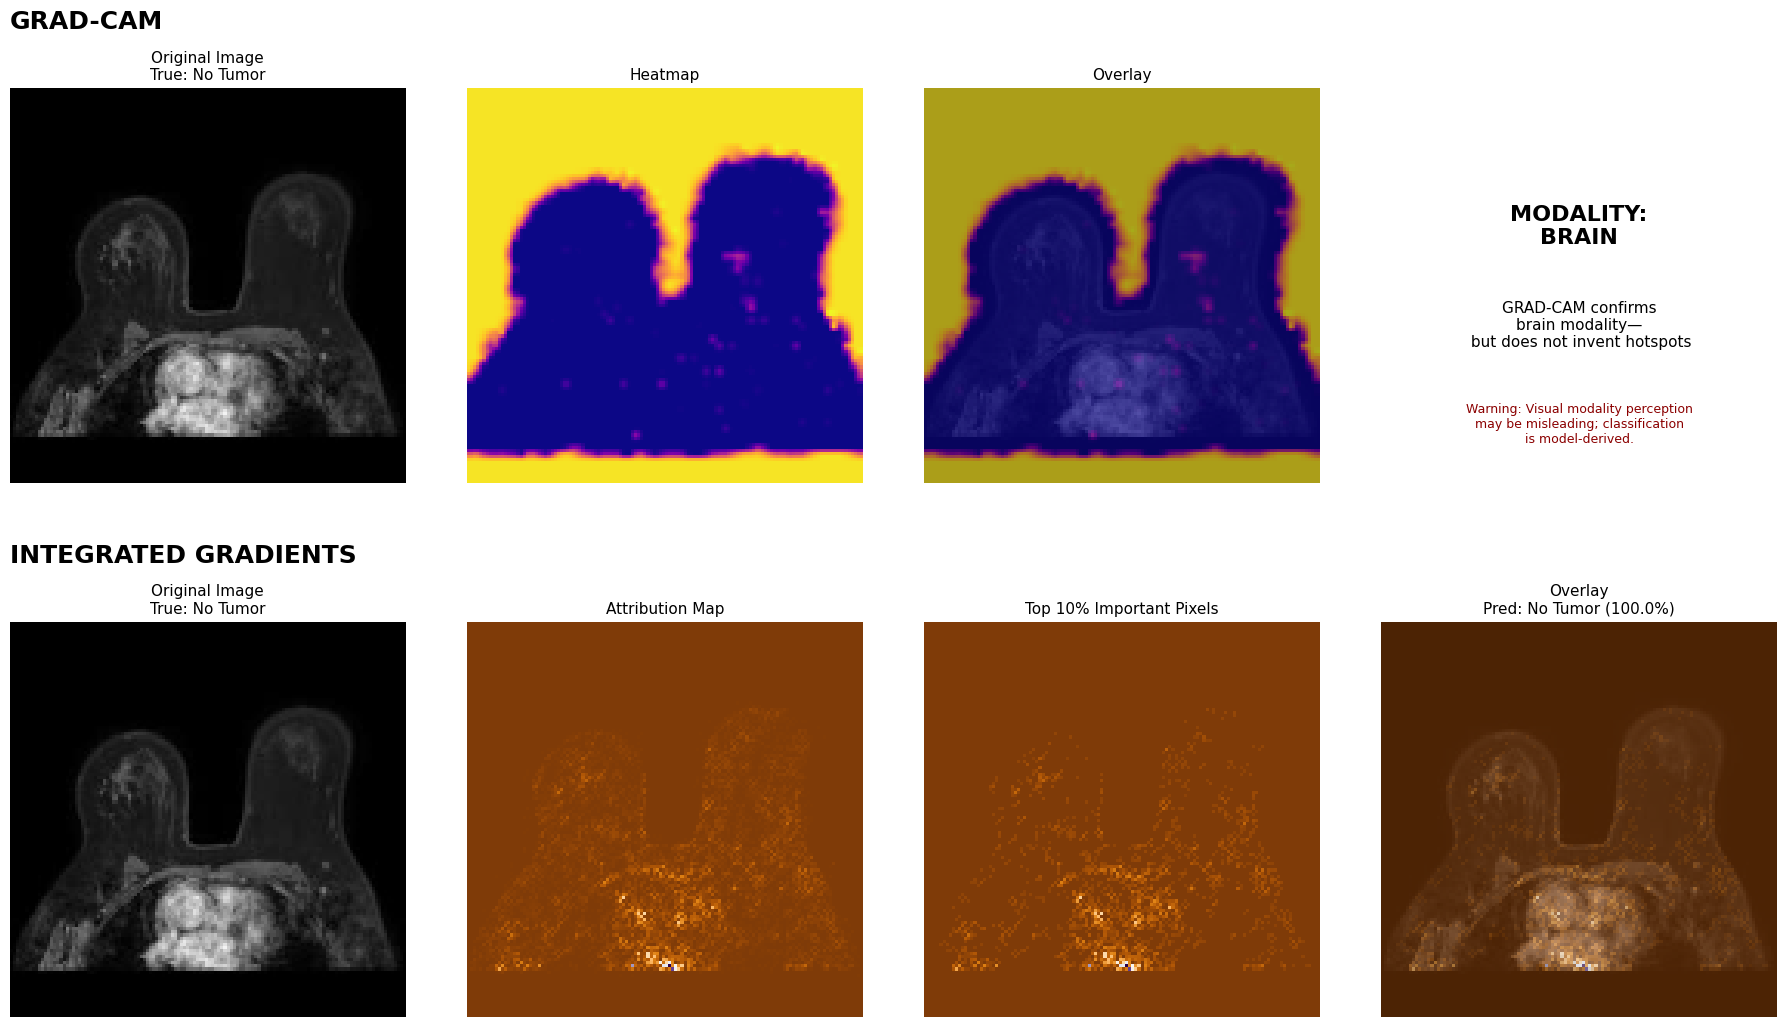

In [72]:
class_names = ['Benign', 'Malignant', 'No Tumor', 'Glioma Tumor', 'Meningioma Tumor', 'Pituitary Tumor']

sample_idx = 50
sample_img = X_test[sample_idx]
true_lbl = class_names[np.argmax(y_test[sample_idx])]

# Get prediction
pred_probs = model.predict(np.expand_dims(sample_img, axis=0), verbose=0)[0]
pred_class = np.argmax(pred_probs)
confidence = pred_probs[pred_class] * 100

# Determine modality
if class_names[pred_class] in ['No Tumor', 'Glioma Tumor', 'Pituitary Tumor', 'Meningioma Tumor']:
    modality = "BRAIN"
else:
    modality = "BREAST"

print(f"{modality} MRI SCAN: {class_names[pred_class]}")
print("Computing GRAD-CAM...")
grad_vis, grad_out = grad_cam(model, sample_img, pred_class)

print("Computing Integrated Gradients (this takes up to 10 seconds)...")
attributions, preds = integrated_gradients(model, sample_img, pred_class, steps=100)

# Process IG attributions
attr_magnitude = np.sum(np.abs(attributions), axis=-1)
attr_magnitude = attr_magnitude / (attr_magnitude.max() + 1e-10)
threshold = np.percentile(attr_magnitude, 90)
attr_thresholded = np.where(attr_magnitude > threshold, attr_magnitude, 0)

# Create 2x4 figure
fig, axes = plt.subplots(2, 4, figsize=(18, 10))

# ============= ROW TITLES (above each row) =============
axes[0, 0].annotate('GRAD-CAM', xy=(0, 1.15), xycoords='axes fraction', 
                     fontsize=18, fontweight='bold', ha='left')
axes[1, 0].annotate('INTEGRATED GRADIENTS', xy=(0, 1.15), xycoords='axes fraction', 
                     fontsize=18, fontweight='bold', ha='left')

# ============= TOP ROW: GRAD-CAM =============
axes[0, 0].imshow(sample_img)
axes[0, 0].set_title(f'Original Image\nTrue: {true_lbl}', fontsize=11)
axes[0, 0].axis('off')

axes[0, 1].imshow(grad_vis, cmap='plasma')
axes[0, 1].set_title('Heatmap', fontsize=11)
axes[0, 1].axis('off')

axes[0, 2].imshow(sample_img)
axes[0, 2].imshow(grad_vis, cmap='plasma', alpha=0.7)
axes[0, 2].set_title('Overlay', fontsize=11)
axes[0, 2].axis('off')

axes[0, 3].axis('off')
axes[0, 3].text(0.5, 0.65, f"MODALITY:\n{modality}", ha='center', va='center', fontsize=16, fontweight='bold')
axes[0, 3].text(0.5, 0.4, "GRAD-CAM confirms\nbrain modality—\n but does not invent hotspots", ha='center', va='center', fontsize=11)
axes[0, 3].text(0.5, 0.15, "Warning: Visual modality perception\nmay be misleading; classification\nis model-derived.", ha='center', va='center', fontsize=9, color='darkred', bbox=dict(facecolor='white', alpha=0.7, edgecolor='none'))

# ============= BOTTOM ROW: INTEGRATED GRADIENTS =============
axes[1, 0].imshow(sample_img)
axes[1, 0].set_title(f'Original Image\nTrue: {true_lbl}', fontsize=11)
axes[1, 0].axis('off')

axes[1, 1].imshow(attr_magnitude, cmap='PuOr')
axes[1, 1].set_title('Attribution Map', fontsize=11)
axes[1, 1].axis('off')

axes[1, 2].imshow(attr_thresholded, cmap='PuOr')
axes[1, 2].set_title('Top 10% Important Pixels', fontsize=11)
axes[1, 2].axis('off')

axes[1, 3].imshow(sample_img)
axes[1, 3].imshow(attr_thresholded, cmap='PuOr', alpha=0.6)
axes[1, 3].set_title(f'Overlay\nPred: {class_names[pred_class]} ({confidence:.1f}%)', fontsize=11)
axes[1, 3].axis('off')

plt.tight_layout()
plt.subplots_adjust(hspace=0.35)  # Add space between rows for the titles
plt.show()

### Case 3 — Brain MRI With No Tumor (human perception bias)
**Human Perception Challenge**

- Some axial brain MRI slices can visually resemble breast MRI cross-sections. To an untrained observer — and sometimes even to students in medical imaging courses — this can cause modality confusion, especially when:

  - the slice omits brainstem/spinal context

  - the field-of-view is tightly cropped

  - fat-suppression/pulse sequences reduce contrast differences

  - This case demonstrates how surface-level appearance can mislead human intuition, while the model uses deeper spatial cues.

- GRAD CAM
    - highlights overall brain shape and inner structures, not just the outside edges
    - attention is spread across large regions, showing the model is checking the general layout of the scan
    - this helps confirm that the model recognizes the image as a brain, even when people might guess differently just by looking quickly
- Integrated Gradients
    - no strong “hot spots”, which is what we expect when there’s no tumor present
    - small attributions appear around normal structural changes in the scan, meaning the model isn’t just reacting to noise
    - the lack of strong signals helps reinforce that the model is not falsely detecting a tumor

**Takeaway**:Even when humans might confuse the scan for another body part, the explainability maps show the model is still reasoning like a “brain detector.” And because there’s no tumor, both methods show weak or diffuse signals — which is exactly what we want in a negative case.

### CASE 4: LOW CONFIDENCE PREDICTION

BRAIN MRI SCAN: No Tumor
Computing GRAD-CAM...
Computing Integrated Gradients (this takes up to 10 seconds)...


C:\Users\vihar\AppData\Local\Temp\ipykernel_8480\1048659639.py:111: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


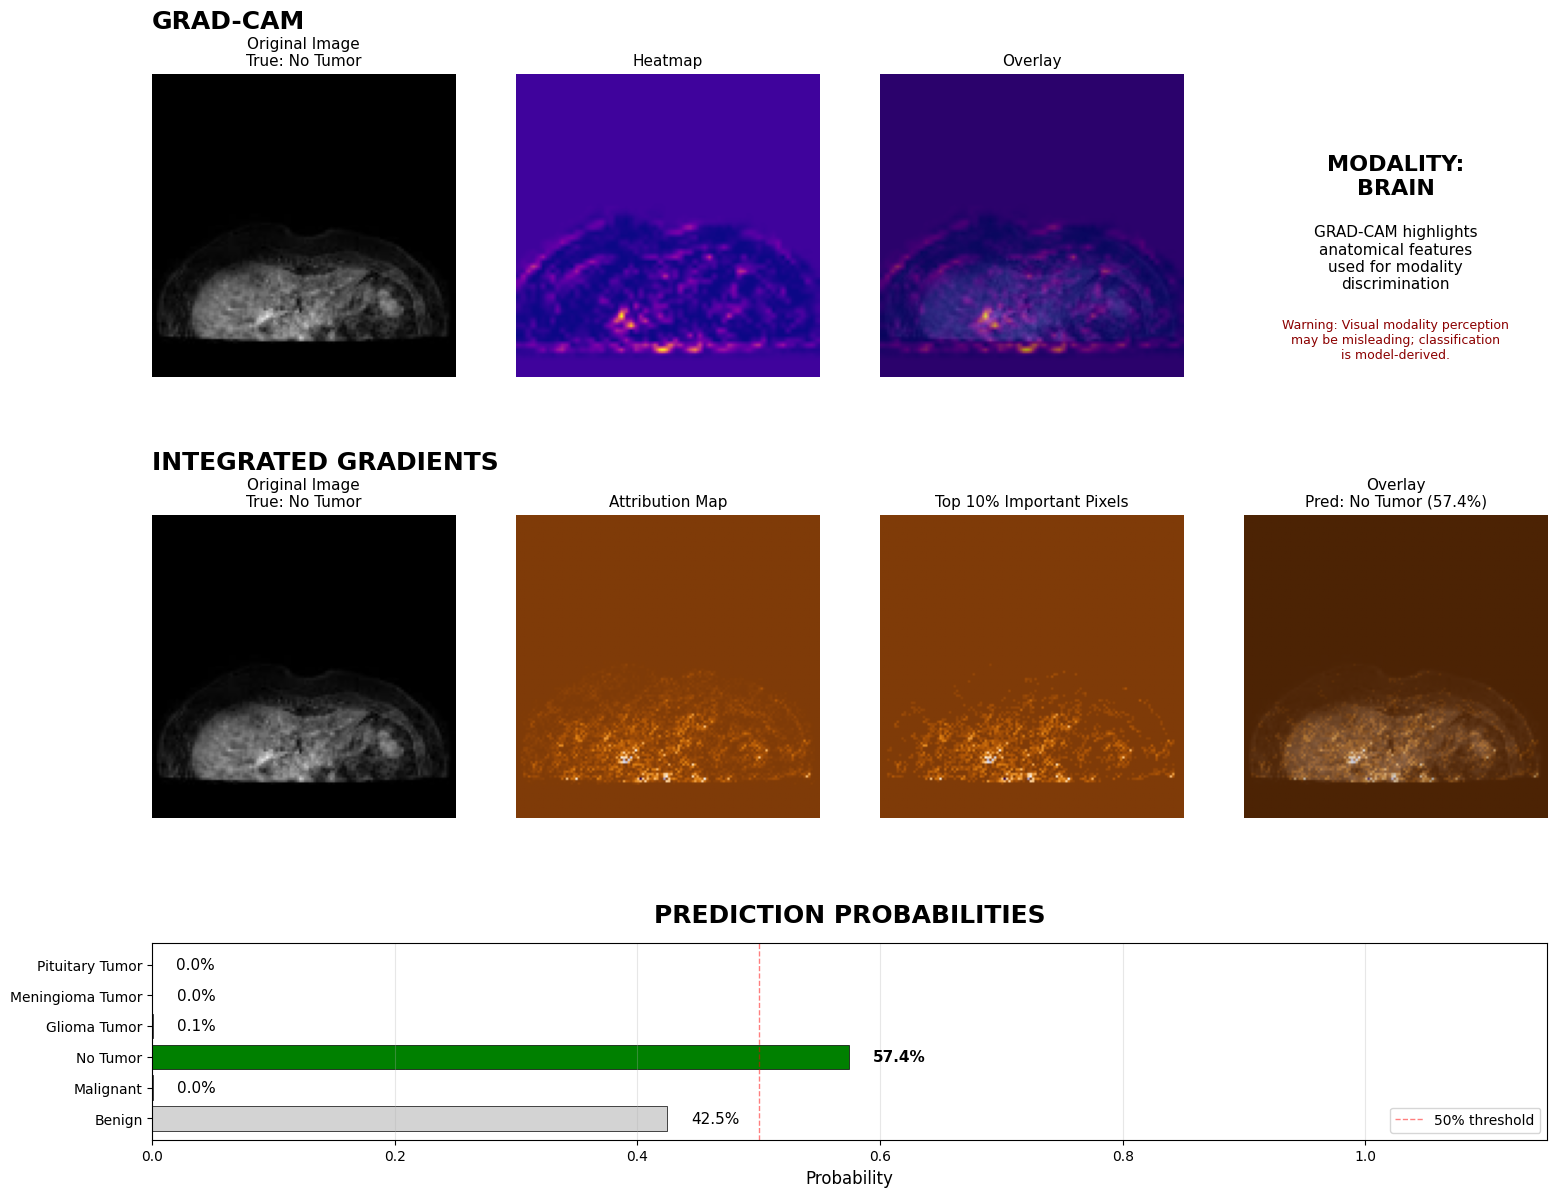

In [ ]:
class_names = ['Benign', 'Malignant', 'No Tumor', 'Glioma Tumor', 'Meningioma Tumor', 'Pituitary Tumor']

sample_idx = 566
sample_img = X_test[sample_idx]
true_lbl = class_names[np.argmax(y_test[sample_idx])]

# Get prediction
pred_probs = model.predict(np.expand_dims(sample_img, axis=0), verbose=0)[0]
pred_class = np.argmax(pred_probs)
confidence = pred_probs[pred_class] * 100

# Determine modality
if class_names[pred_class] in ['No Tumor', 'Glioma Tumor', 'Pituitary Tumor', 'Meningioma Tumor']:
    modality = "BRAIN"
else:
    modality = "BREAST"

print(f"{modality} MRI SCAN: {class_names[pred_class]}")
print("Computing GRAD-CAM...")
grad_vis, grad_out = grad_cam(model, sample_img, pred_class)

print("Computing Integrated Gradients (this takes up to 10 seconds)...")
attributions, preds = integrated_gradients(model, sample_img, pred_class, steps=100)

# Process IG attributions
attr_magnitude = np.sum(np.abs(attributions), axis=-1)
attr_magnitude = attr_magnitude / (attr_magnitude.max() + 1e-10)
threshold = np.percentile(attr_magnitude, 90)
attr_thresholded = np.where(attr_magnitude > threshold, attr_magnitude, 0)

# Create figure with GridSpec: 2 rows of images + 1 row for bar chart
fig = plt.figure(figsize=(18, 14))
gs = GridSpec(3, 4, figure=fig, height_ratios=[1, 1, 0.6], hspace=0.4)

# ============= ROW 1: GRAD-CAM =============
ax00 = fig.add_subplot(gs[0, 0])
ax01 = fig.add_subplot(gs[0, 1])
ax02 = fig.add_subplot(gs[0, 2])
ax03 = fig.add_subplot(gs[0, 3])

ax00.annotate('GRAD-CAM', xy=(0, 1.15), xycoords='axes fraction', 
              fontsize=18, fontweight='bold', ha='left')

ax00.imshow(sample_img)
ax00.set_title(f'Original Image\nTrue: {true_lbl}', fontsize=11)
ax00.axis('off')

ax01.imshow(grad_vis, cmap='plasma')
ax01.set_title('Heatmap', fontsize=11)
ax01.axis('off')

ax02.imshow(sample_img)
ax02.imshow(grad_vis, cmap='plasma', alpha=0.7)
ax02.set_title('Overlay', fontsize=11)
ax02.axis('off')

ax03.axis('off')
ax03.text(0.5, 0.65, f"MODALITY:\n{modality}", ha='center', va='center', fontsize=16, fontweight='bold')
ax03.text(0.5, 0.4, "GRAD-CAM highlights\n anatomical features ", ha='center', va='center', fontsize=11)
ax03.text(0.5, 0.15, "Warning: Visual modality perception\nmay be misleading; classification\nis model-derived.", ha='center', va='center', fontsize=9, color='darkred', bbox=dict(facecolor='white', alpha=0.7, edgecolor='none'))

# ============= ROW 2: INTEGRATED GRADIENTS =============
ax10 = fig.add_subplot(gs[1, 0])
ax11 = fig.add_subplot(gs[1, 1])
ax12 = fig.add_subplot(gs[1, 2])
ax13 = fig.add_subplot(gs[1, 3])

ax10.annotate('INTEGRATED GRADIENTS', xy=(0, 1.15), xycoords='axes fraction', 
              fontsize=18, fontweight='bold', ha='left')

ax10.imshow(sample_img)
ax10.set_title(f'Original Image\nTrue: {true_lbl}', fontsize=11)
ax10.axis('off')

ax11.imshow(attr_magnitude, cmap='PuOr')
ax11.set_title('Attribution Map', fontsize=11)
ax11.axis('off')

ax12.imshow(attr_thresholded, cmap='PuOr')
ax12.set_title('Top 10% Important Pixels', fontsize=11)
ax12.axis('off')

ax13.imshow(sample_img)
ax13.imshow(attr_thresholded, cmap='PuOr', alpha=0.6)
ax13.set_title(f'Overlay\nPred: {class_names[pred_class]} ({confidence:.1f}%)', fontsize=11)
ax13.axis('off')

# ============= ROW 3: PREDICTION BAR CHART =============
ax_bar = fig.add_subplot(gs[2, :])  # Span all 4 columns

# Create colors: green for predicted class, light gray for others
colors = ['green' if i == pred_class else 'lightgray' for i in range(len(class_names))]

# Create horizontal bar chart
bars = ax_bar.barh(class_names, pred_probs, color=colors, edgecolor='black', linewidth=0.5)

# Add percentage labels on bars
for i, (bar, prob) in enumerate(zip(bars, pred_probs)):
    ax_bar.text(prob + 0.02, bar.get_y() + bar.get_height()/2, 
                f'{prob*100:.1f}%', va='center', fontsize=11, fontweight='bold' if i == pred_class else 'normal')

ax_bar.set_xlim(0, 1.15)
ax_bar.set_xlabel('Probability', fontsize=12)
ax_bar.set_title('PREDICTION PROBABILITIES', fontsize=18, fontweight='bold', pad=15)
ax_bar.axvline(x=0.5, color='red', linestyle='--', linewidth=1, alpha=0.5, label='50% threshold')
ax_bar.legend(loc='lower right')

# Add grid for readability
ax_bar.grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.show()

### Case 4: Low-Confidence Tumor Prediction
- Why this case matters?
  - real world medical scans can be ambigious
  - this case highlights how confidence in output and explanation value drop together
- GRAD CAM
  - GRAD CAM still brings out the anatomical boundaries
  - heatmap is more spread out
- Integrated Gradients
  - IG fails to pinpoint a specific cluster of pixels to attribute to the tumor.
  - far less pixel-level activation than higher confidence predictions

**Takeaway**: When the model is unsure, both explanations become less focused. This pairing between weak confidence and diffuse attribution is a sign the model isn’t hallucinating a tumor — it’s appropriately uncertain.

## 3. Method Comparison

| Method | Strength | Weakness | When to Trust |
|--------|----------|----------|---------------|
| **GRAD-CAM** | Shows coarse regions of model focus; fast computation | Picks up modality + anatomy noise; may miss lesion-specific features | Architecture-level debugging; verifying anatomical focus |
| **Integrated Gradients** | Pinpoints pixel-level lesion contributors; theoretically grounded | Sensitive to baseline choice; computationally expensive | Lesion explainability; clinical decision support |

## 4. What these explanations tell us

Across all cases:
- **Grad-CAM** consistently shows *where the model looks in a broad sense*, often tied to anatomy and modality.
- **Integrated Gradients** shows *which specific pixels matter*, especially when the model is confident.
- When **no tumor is present**, both methods avoid inventing hotspots — a positive sign for safety.
- When the **model is uncertain**, both maps become diffuse, matching low confidence rather than hallucinating patterns.

### Bottom Line
For this classifier:
- **Grad-CAM = modality + structure sanity check**
- **Integrated Gradients = lesion evidence**
- **Confidence + explanations together** indicate whether the model is reasoning or guessing

Explanations don't replace evaluation —  
but they give insight into *how the model arrives at a diagnosis*.
